In [78]:
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow
import seaborn as sns
import zipfile
import dlib
import numpy as np
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,BatchNormalization,Dropout,GlobalAvgPool2D,Input
from tensorflow.keras.models import Model,save_model,model_from_json
from tensorflow.keras.applications import ResNet50,Xception,InceptionV3
from sklearn.metrics import accuracy_score,classification_report


In [4]:
zip=zipfile.ZipFile('/content/fer2013_2_classes.zip')

In [5]:
zip.extractall('./')
zip.close()

In [6]:
img=cv2.imread('/content/fer2013_2_classes/train/Angry/0.jpg')

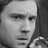

In [7]:
cv2_imshow(img)

In [8]:
img.shape

(48, 48, 3)

In [9]:
generator=ImageDataGenerator(rotation_range=10,horizontal_flip=True,rescale=1./255)

In [10]:
train=generator.flow_from_directory('/content/fer2013_2_classes/train',target_size=(48,48),batch_size=32,shuffle=True)

Found 11210 images belonging to 2 classes.


In [11]:
train.class_indices

{'Angry': 0, 'Happy': 1}

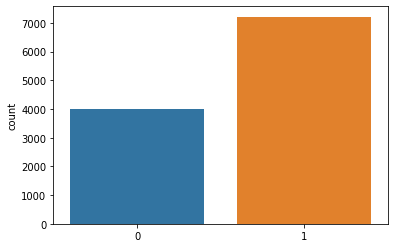

In [12]:
sns.countplot(x=train.classes);

In [13]:
model=ResNet50(include_top=False,input_shape=(48,48,3))

94773248/94765736 [==============================] - 1s 0us/step


In [14]:
len(model.layers)

175

In [15]:
my_model=model.output
my_model=GlobalAvgPool2D()(my_model)
my_model=Dense(1024,activation='relu')(my_model)
my_model=BatchNormalization()(my_model)
my_model=Dense(512,activation='relu')(my_model)
my_model=Dropout(0.3)(my_model)
my_model=Dense(124,activation='relu')(my_model)
my_model=Dropout(0.3)(my_model)
my_model=Dense(2,activation='softmax')(my_model)

In [16]:
actual_model=Model(model.input,my_model)

In [17]:
actual_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [18]:
for layer in model.layers[:135]:
  layer.trainable=False

In [19]:
actual_model.compile(optimizer='Adam', loss='CategoricalCrossentropy', metrics=['accuracy'])

In [20]:
history=actual_model.fit(train,epochs=50)

Epoch 1/50
351/351 [==============================] - 51s 43ms/step - loss: 0.7634 - accuracy: 0.6016
Epoch 2/50
351/351 [==============================] - 15s 42ms/step - loss: 0.5873 - accuracy: 0.6872
Epoch 3/50
351/351 [==============================] - 15s 41ms/step - loss: 0.5601 - accuracy: 0.7136
Epoch 4/50
351/351 [==============================] - 15s 42ms/step - loss: 0.5443 - accuracy: 0.7315
Epoch 5/50
351/351 [==============================] - 15s 41ms/step - loss: 0.5333 - accuracy: 0.7326
Epoch 6/50
351/351 [==============================] - 15s 42ms/step - loss: 0.5217 - accuracy: 0.7408
Epoch 7/50
351/351 [==============================] - 15s 41ms/step - loss: 0.5255 - accuracy: 0.7423
Epoch 8/50
351/351 [==============================] - 15s 42ms/step - loss: 0.5133 - accuracy: 0.7414
Epoch 9/50
351/351 [==============================] - 15s 42ms/step - loss: 0.5065 - accuracy: 0.7475
Epoch 10/50
351/351 [==============================] - 15s 42ms/step - loss: 0.492

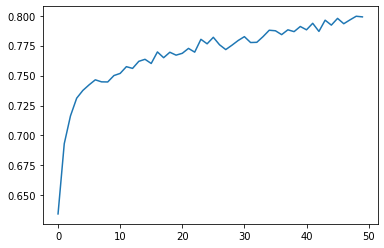

In [21]:
sns.lineplot(x=range(50),y=history.history['accuracy'])

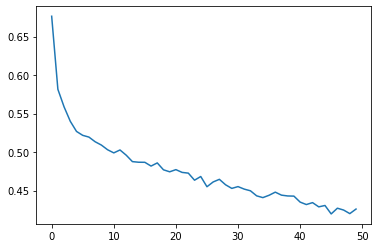

In [22]:
sns.lineplot(x=range(50),y=history.history['loss'])

In [26]:
test_generator=ImageDataGenerator(rescale=1./255)
test=test_generator.flow_from_directory('/content/fer2013_2_classes/validation',batch_size=1,target_size=(48,48),shuffle=False)

Found 1370 images belonging to 2 classes.


In [32]:
pred=actual_model.predict(test)

In [40]:
accuracy_score(test.classes,np.argmax(pred,axis=1))

0.6416058394160584

In [43]:
print(classification_report(test.classes,np.argmax(pred,axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       491
           1       0.64      1.00      0.78       879

    accuracy                           0.64      1370
   macro avg       0.32      0.50      0.39      1370
weighted avg       0.41      0.64      0.50      1370



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
new_model=tensorflow.keras.models.Sequential([
                                              Conv2D(32,(2,2),padding='same',activation='relu',input_shape=(48,48,3)),
                                              BatchNormalization(),
                                              Conv2D(64,(2,2),padding='same',activation='relu'),
                                              BatchNormalization(),
                                              MaxPool2D(),
                                              Dropout(0.3),

                                              Conv2D(64,(2,2),padding='same',activation='relu'),
                                              BatchNormalization(),
                                              Conv2D(124,(2,2),padding='same',activation='relu'),
                                              BatchNormalization(),
                                              MaxPool2D(),
                                              Dropout(0.3),

                                              Conv2D(124,(2,2),padding='same',activation='relu'),
                                              BatchNormalization(),
                                              Conv2D(256,(2,2),padding='same',activation='relu'),
                                              BatchNormalization(),
                                              MaxPool2D(),
                                              Dropout(0.3),

                                              GlobalAvgPool2D(),
                                              Dense(512,activation='relu'),
                                              BatchNormalization(),
                                              Dense(256,activation='relu'),
                                              BatchNormalization(),
                                              Dense(124,activation='relu'),
                                              Dropout(0.2),
                                              Dense(2,activation='softmax')


])

In [53]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 48, 48, 32)        416       
_________________________________________________________________
batch_normalization_22 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 48, 48, 64)        8256      
_________________________________________________________________
batch_normalization_23 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 24, 24, 64)       

In [56]:
new_model.compile(optimizer='Adam', loss='CategoricalCrossentropy', metrics=['accuracy'])

In [57]:
new_history=new_model.fit(train,epochs=50)

Epoch 1/50
351/351 [==============================] - 14s 35ms/step - loss: 0.8122 - accuracy: 0.5789
Epoch 2/50
351/351 [==============================] - 12s 34ms/step - loss: 0.6444 - accuracy: 0.6427
Epoch 3/50
351/351 [==============================] - 12s 34ms/step - loss: 0.5520 - accuracy: 0.7161
Epoch 4/50
351/351 [==============================] - 12s 34ms/step - loss: 0.4718 - accuracy: 0.7714
Epoch 5/50
351/351 [==============================] - 12s 35ms/step - loss: 0.4314 - accuracy: 0.7936
Epoch 6/50
351/351 [==============================] - 12s 35ms/step - loss: 0.3963 - accuracy: 0.8110
Epoch 7/50
351/351 [==============================] - 12s 35ms/step - loss: 0.3524 - accuracy: 0.8400
Epoch 8/50
351/351 [==============================] - 12s 35ms/step - loss: 0.3413 - accuracy: 0.8496
Epoch 9/50
351/351 [==============================] - 12s 34ms/step - loss: 0.3231 - accuracy: 0.8600
Epoch 10/50
351/351 [==============================] - 12s 34ms/step - loss: 0.298

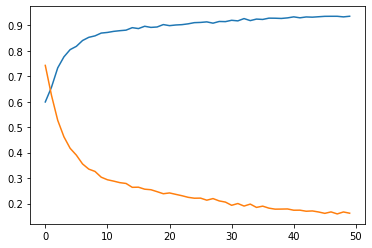

In [59]:
sns.lineplot(x=range(50),y=new_history.history['accuracy'])
sns.lineplot(x=range(50),y=new_history.history['loss'])

In [60]:
pred_new=new_model.predict(test)

In [61]:
accuracy_score(test.classes,np.argmax(pred_new,axis=1))

0.9255474452554745

In [64]:
print(classification_report(test.classes,np.argmax(pred_new,axis=1)))

              precision    recall  f1-score   support

           0       0.95      0.84      0.89       491
           1       0.92      0.97      0.94       879

    accuracy                           0.93      1370
   macro avg       0.93      0.91      0.92      1370
weighted avg       0.93      0.93      0.92      1370



In [71]:
model_json=new_model.to_json()

In [74]:
with open('my_model.json','w') as file:
  file.write(model_json)

In [77]:
save_model(new_model,'/content/my_model.hdf5')